In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
path = "/content/drive/MyDrive/CrackConcreteDataset"

In [ ]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        '''image_path ="/content/drive/MyDrive/CrackConcreteDataset/Train/images"'''
        ''''mask_path = "/content/drive/MyDrive/CrackConcreteDataset/Train/masks"'''
        image_path=self.path+"/images/"+id_name

        mask_path=self.path+"/masks/"+id_name

        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        mask = cv2.imread(mask_path, -1)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask=np.expand_dims(mask, axis=-1)
        image = image/255.0
        mask = mask/255.0

        return image, mask

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        image = []
        mask  = []

        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)

        return image,mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
import math
image_size = 128
train_path = "/content/drive/MyDrive/CrackConcreteDataset/Train/images"
epochs = 25
batch_size = 8

train_ids=os.listdir(train_path)

val_data_size = math.ceil(0.1*len(train_ids))

val_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]


In [ ]:

train_path = "/content/drive/MyDrive/CrackConcreteDataset/Train"
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)


(8, 128, 128, 3) (8, 128, 128, 1)


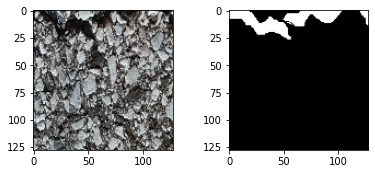

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")


In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c



In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))

    p0 = inputs
    c1, p1 = down_block(p0, f[0])
    c2, p2 = down_block(p1, f[1])
    c3, p3 = down_block(p2, f[2])
    c4, p4 = down_block(p3, f[3])

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3])
    u2 = up_block(u1, c3, f[2])
    u3 = up_block(u2, c2, f[1])
    u4 = up_block(u3, c1, f[0])

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### Training Phase

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(val_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(val_ids)//batch_size

In [ ]:
x, y = valid_gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


In [ ]:

hist = model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=25)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
332/332 [==============================] - 1201s 4s/step - loss: 0.1640 - acc: 0.9364 - val_loss: 0.1251 - val_acc: 0.9360
Epoch 2/25
332/332 [==============================] - 198s 596ms/step - loss: 0.1263 - acc: 0.9415 - val_loss: 0.1168 - val_acc: 0.9389
Epoch 3/25
332/332 [==============================] - 101s 304ms/step - loss: 0.1280 - acc: 0.9403 - val_loss: 0.1018 - val_acc: 0.9436
Epoch 4/25
332/332 [==============================] - 95s 286ms/step - loss: 0.1130 - acc: 0.9457 - val_loss: 0.1116 - val_acc: 0.9406
Epoch 5/25
332/332 [==============================] - 93s 282ms/step - loss: 0.1085 - acc: 0.9463 - val_loss: 0.0991 - val_acc: 0.9431
Epoch 6/25
332/332 [==============================] - 94s 283ms/step - loss: 0.1041 - acc: 0.9462 - val_loss: 0.0977 - val_acc: 0.9440
Epoch 7/25
332/332 [==============================] - 93s 280ms/step - loss: 0.0961 - acc: 0.9489 - val_loss: 0.0876 - val_acc: 0.9474
Epoch 8/25
332/332 [==============================] - 

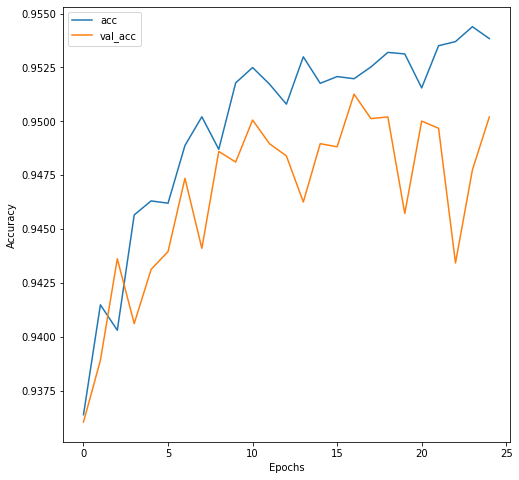

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(hist.history["acc"], label="acc")
plt.plot(hist.history["val_acc"], label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

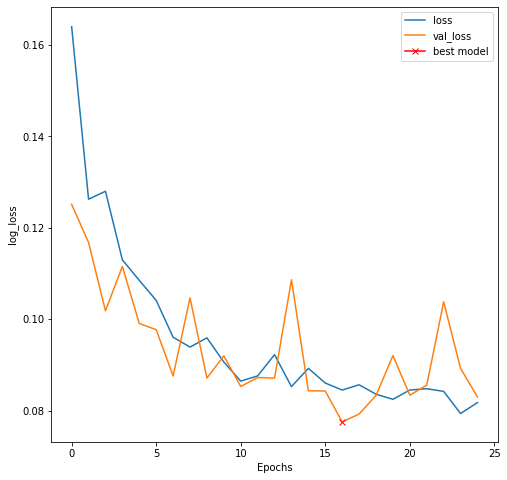

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(hist.history["val_loss"]), np.min(hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
x, y = valid_gen.__getitem__(10)
result = model.predict(x)

result = result > 0.5

In [ ]:
y.shape

(8, 128, 128, 1)

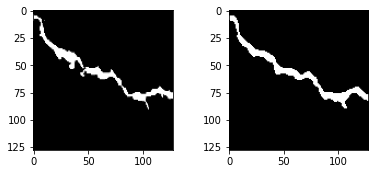

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

### Testing Phase

In [ ]:
test_path = "/content/drive/MyDrive/CrackConcreteDataset/Test"
test_ids=os.listdir(test_path+"/images")
test_gen = DataGen(test_ids, test_path, image_size=image_size, batch_size=batch_size)

In [ ]:
x, y = test_gen.__getitem__(6)
result = model.predict(x)

result = result > 0.5


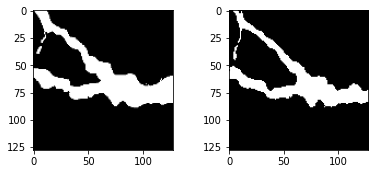

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[7]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[7]*255, (image_size, image_size)), cmap="gray")

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[7]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[7]*255, (image_size, image_size)), cmap="gray")

In [ ]:
x, y = test_gen.__getitem__(10)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[7]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[7]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[7])

In [ ]:
import cv2
import cv2 as cv
import numpy as np
img_original=x[7]
mask=np.reshape(result[7]*255, (image_size, image_size))
mask.shape

mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)

blue =np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''
new_img[new_img>255]=255
for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      new_img[i][j]=blue
plt.imshow(new_img)

In [ ]:
x, y = test_gen.__getitem__(4)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[0])

In [ ]:
import cv2
import cv2 as cv
import numpy as np
img_original=x[0]
mask=np.reshape(result[0]*255, (image_size, image_size))
mask.shape

mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)

blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''

new_img[new_img>255]=255

for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      new_img[i][j]=blue
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_original)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(new_img)


In [ ]:
x, y = test_gen.__getitem__(4)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[7]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[7]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[7])

In [ ]:
import cv2
import cv2 as cv
import numpy as np
img_original=x[7]
mask=np.reshape(result[7]*255, (image_size, image_size))
mask.shape

mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)

blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''
new_img[new_img>255]=255
for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      new_img[i][j]=blue
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_original)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(new_img)

In [ ]:
x, y = test_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[0])

In [ ]:
import cv2
import cv2 as cv
import numpy as np
img_original=x[0]
mask=np.reshape(result[0]*255, (image_size, image_size))
mask.shape

mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)

blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''
new_img[new_img>255]=255
for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      new_img[i][j]=blue
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_original)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(new_img)

In [ ]:
x, y = test_gen.__getitem__(11)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[1])


In [ ]:
import cv2
import cv2 as cv
import numpy as np
img_original=x[1]
mask=np.reshape(result[1]*255, (image_size, image_size))
mask.shape

mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)

blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''

new_img[new_img>255]=255

for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):

      new_img[i][j]=blue
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_original)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(new_img)

In [ ]:
x, y = test_gen.__getitem__(12)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[7]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[7]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[7])

In [ ]:
import cv2
import cv2 as cv
import numpy as np
img_original=x[7]
mask=np.reshape(result[7]*255, (image_size, image_size))
mask.shape

mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)

blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''
new_img[new_img>255]=255
for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      new_img[i][j]=blue
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_original)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(new_img)

In [ ]:
import math
image_size = 128
test_path = "/content/drive/MyDrive/CrackConcreteDataset/Test/images"
epochs = 25
batch_size = 8

## Testing ids.
test_ids=os.listdir(test_path)

actual_mask = []
predicted_mask = []

test_path = "/content/drive/MyDrive/CrackConcreteDataset/Test"
test_gen = DataGen(test_ids, test_path, image_size=image_size, batch_size=batch_size)

test_steps = len(test_ids)//batch_size

In [ ]:
model.evaluate_generator(test_gen, steps=test_steps, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)